In [3]:
import numpy as np
import pickle
import os
import re
import pandas as pd
from tqdm import tqdm
import glob
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use("qt5agg")

import sys
sys.path.append("../../scripts") # TODO: make this part of pythonpath?


from scripts.run_bubblewrap import BubblewrapRun, default_rwd_parameters, run_bubblewrap


In [4]:
def simple_run(file, parameters):
    bw, moviewriter = run_bubblewrap(file, parameters, keep_every_nth_frame=None)
    # plot_bubblewrap_results(bw)
    br = BubblewrapRun(bw, file=file, bw_parameters=parameters)
    br.save(directory=".")
    return br


In [5]:
br = simple_run("../datasets/jpca_reduced.npy", dict(default_rwd_parameters))
br.outfile

  0%|                                                                                                                      | 0/2268 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [16]:
datasets = pd.DataFrame(columns=["old_way_file", "new_way_file", "shuffled_old_way_file", "shuffled_new_way_file", "has_A", "has_states", "sampling_rate"])


datasets.loc['monkey reach'] = \
    dict(
        old_way_file = "bubblewrap_run_2023-04-27-11-41-57.pickle",
        new_way_file = "bubblewrap_run_2023-04-27-11-42-12.pickle",
        shuffled_new_way_file = 'bubblewrap_run_2023-05-02-17-41-05.pickle',
        has_A = True,
        has_states = False,
        sampling_rate=100,
    )

datasets.loc['widefield'] = \
    dict(
        old_way_file = 'bubblewrap_run_2023-04-27-15-25-37.pickle',
        new_way_file = 'bubblewrap_run_2023-04-27-15-32-54.pickle',
        shuffled_new_way_file = 'bubblewrap_run_2023-05-02-17-58-25.pickle',
        has_A = False,
        has_states = False,
        sampling_rate = 30,
    )

datasets.loc['mouse'] = \
    dict(
        old_way_file = 'bubblewrap_run_2023-05-03-14-56-18.pickle',
        new_way_file ='bubblewrap_run_2023-05-03-15-16-01.pickle',
        shuffled_new_way_file = 'bubblewrap_run_2023-05-03-16-14-39.pickle',
        has_A = False,
        has_states = False,
        sampling_rate = 30,
    )

datasets.loc['neuropixel'] = \
    dict(
        old_way_file = 'bubblewrap_run_2023-04-27-14-55-21.pickle',
        new_way_file = 'bubblewrap_run_2023-04-27-15-01-37.pickle',
        shuffled_new_way_file = 'bubblewrap_run_2023-05-02-17-49-17.pickle',
        has_A = False,
        has_states = False,
        sampling_rate=33.3,
    )





In [17]:
datasets

,old_way_file,new_way_file,shuffled_old_way_file,shuffled_new_way_file,has_A,has_states,sampling_rate
monkey reach,bubblewrap_run_2023-04-27-11-41-57.pickle,bubblewrap_run_2023-04-27-11-42-12.pickle,NaN,bubblewrap_run_2023-05-02-17-41-05.pickle,True,False,100.0
widefield,bubblewrap_run_2023-04-27-15-25-37.pickle,bubblewrap_run_2023-04-27-15-32-54.pickle,NaN,bubblewrap_run_2023-05-02-17-58-25.pickle,False,False,30.0
mouse,bubblewrap_run_2023-05-03-14-56-18.pickle,bubblewrap_run_2023-05-03-15-16-01.pickle,NaN,bubblewrap_run_2023-05-03-16-14-39.pickle,False,False,30.0
neuropixel,bubblewrap_run_2023-04-27-14-55-21.pickle,bubblewrap_run_2023-04-27-15-01-37.pickle,NaN,bubblewrap_run_2023-05-02-17-49-17.pickle,False,False,33.3


In [9]:
np.nonzero(np.isnan([0,0,np.nan, np.nan]))

(array([2, 3]),)

In [10]:
def process(x):
    return list(map(float,x.split("\n")))

BW0 = process("""4.36810431293877
4.338014042126332
4.0672016048143975
4.007021063189524
4.0672016048143975
3.8264794383149""")

VJF = process("""-3.304914744232704
-3.5155466399197692
-3.756268806419266
-3.9669007021063294
-4.6890672016048125
-3.0341023069207793""")

ZP = process("""3.7362086258775893
3.1945837512537203
-5.651955867602808
-5.8324974924774295
-14.438314944834456
-27.828485456368995""")

BW2 = process("""5.356481481481481
5.273148148148147
5.208333333333332
5.185185185185184
5.166666666666666
5.152777777777777""")

BW3 = process("""-11.193511008111246
-11.1008111239861
-11.100811123986102
-11.054461181923529
-11.100811123986102
-10.961761297798382""")

BW4 = process("""-12.853932584269664
-13.01123595505618
-12.878901373283396
-12.938826466916355
-12.91136079900125
-12.921348314606742""")

In [32]:
%matplotlib qt
distances = np.array([1,2,3,4,5,10])
fig, axs = plt.subplots(nrows=1, ncols=4, tight_layout=True)

def plot_for_distances(file, ax, shuffled=False):
    with open(file, "rb") as fhan:
        br = pickle.load(fhan)
    line = []
    for distance in distances:
        index = br.bw_parameters['lookahead_steps'].index(distance)
        pred = br.pred_list[:,index]
        end = -1 if not np.any(np.isnan(pred)) else np.nonzero(np.isnan(pred))[0][0]
        pred = pred[:end]
        line.append(pred[pred.size//2:].mean())
    if not shuffled:
        ax.plot(distances, line, '.-', label="local BW")
    else:
        ax.plot(distances, line, 'k--', label="shuffled")

for i, dataset in enumerate(datasets.index):
    plot_for_distances(datasets.loc[dataset].new_way_file,axs[i])
    plot_for_distances(datasets.loc[dataset].shuffled_new_way_file,axs[i], shuffled=True)
    axs[i].set_xticks(distances)
    axs[i].set_xticklabels([f"{x}\n{x/datasets.loc[dataset].sampling_rate*1000:.0f}" for x in distances])
    
    
axs[0].plot(distances, BW0, '.-', color="#ff4400", label='BW')
axs[0].plot(distances, VJF, '.-', color="k", label="VJF")
axs[0].plot(distances, ZP, '.-', color="#be00be", label="ZP")


axs[1].plot(distances, BW2, '.-', color="#ff4400", label='BW')
axs[2].plot(distances, BW3, '.-', color="#ff4400", label='BW')
axs[3].plot(distances, BW4, '.-', color="#ff4400", label='BW')

axs[0].legend()

axs[0].set_title("Monkey reach")
axs[1].set_title("Widefield")
axs[2].set_title("Mouse video")
axs[3].set_title("Neuropixels")

axs[0].set_ylabel("average prediction")
axs[0].set_xlabel("time (steps & ms)")


Text(0.5, 0, 'time (steps & ms)')

In [2]:
def one_sided_ewma(data, com):
    return pd.DataFrame(data=dict(data=data)).ewm(com).mean()["data"].to_numpy()

%matplotlib inline
all_inline = True

In [3]:
files = glob.glob("*pickle")
files.sort()
files = files[-20:]
files

['bubblewrap_run_2023-05-12-16-34-59.pickle',
 'bubblewrap_run_2023-05-12-16-35-05.pickle',
 'bubblewrap_run_2023-05-12-16-35-12.pickle',
 'bubblewrap_run_2023-05-12-16-35-18.pickle',
 'bubblewrap_run_2023-05-12-16-35-24.pickle',
 'bubblewrap_run_2023-05-12-16-35-30.pickle',
 'bubblewrap_run_2023-05-12-16-35-37.pickle',
 'bubblewrap_run_2023-05-12-16-35-42.pickle',
 'bubblewrap_run_2023-05-12-16-35-48.pickle',
 'bubblewrap_run_2023-05-12-16-35-54.pickle',
 'bubblewrap_run_2023-05-12-16-36-00.pickle',
 'bubblewrap_run_2023-05-12-16-36-07.pickle',
 'bubblewrap_run_2023-05-12-16-36-12.pickle',
 'bubblewrap_run_2023-05-12-16-36-19.pickle',
 'bubblewrap_run_2023-05-12-16-36-25.pickle',
 'bubblewrap_run_2023-05-12-16-36-31.pickle',
 'bubblewrap_run_2023-05-12-16-36-37.pickle',
 'bubblewrap_run_2023-05-12-16-36-42.pickle',
 'bubblewrap_run_2023-05-12-16-36-49.pickle',
 'bubblewrap_run_2023-05-12-16-36-56.pickle']

In [6]:
ent_path = np.load("../other/jpca_paper_ent.npy")
pred_path = np.load("../other/jpca_paper_pred.npy")
pred_interp = np.interp(np.arange(0,round(pred_path[-1,0])), pred_path[:,0], pred_path[:,1])
ent_interp = np.interp(np.arange(0,round(ent_path[-1,0])), ent_path[:,0], ent_path[:,1])


4.418909700794173

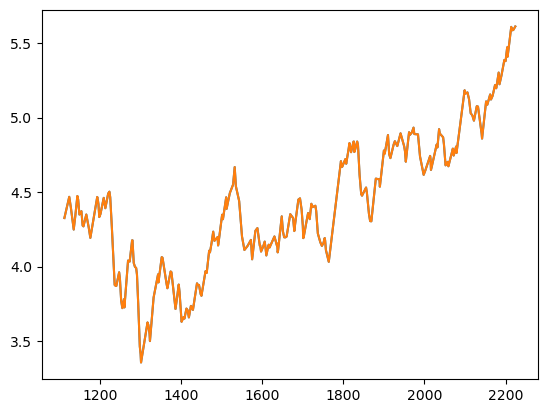

In [7]:
last_half = pred_interp[pred_interp.shape[0]//2:]
x = np.arange(0,pred_interp.shape[0])[pred_interp.shape[0]//2:]
plt.plot(x, last_half)
plt.plot(x,pred_interp[pred_interp.shape[0]//2:])
last_half.mean()

In [8]:

def plot_figure_4(brs, recovered_plots = False):
    ps = [br.bw_parameters for br in brs]
    keys = set([leaf for tree in ps for leaf in tree.keys()])
    keep_keys = []
    for key in keys:
        values = [d[key] for d in ps]
        if not all([values[0] == v for v in values]):
            keep_keys.append(key)
    to_print = []
    for key in keep_keys:
        to_print.append(f"{key}: {[p[key] for p in ps]}")
    
    for p in to_print:
        print(p)
    
    fig, ax = plt.subplots(figsize=(5,5))
    ax2 = ax.twinx()
    
    if recovered_plots:
        ax.plot(pred_path[:,0], pred_path[:,1], 'k')
        ax2.plot(ent_path[:,0], ent_path[:,1], 'k')
        ax.text(1800,-10, f"~{pred_interp[pred_interp.shape[0]//2:].mean():.2f}", color='k')
        ax.text(1500,-10,f"~{ent_interp[ent_interp.shape[0]//2:].mean():.2f}", color='k')



    smooting_scale = 100
    
    for idx, br in enumerate(brs):
        
        # predictions = br.pred_list[br.bw_parameters["M"]+1:,0]
        predictions = br.pred_list[:,0]
        smoothed_predictions = one_sided_ewma(predictions,smooting_scale)

        ax.plot(predictions, alpha=0.25, color='blue')
        c = 'black' if idx ==0 and not recovered_plots else 'blue'
        ax.plot(smoothed_predictions, color=c, label = br.outfile.split("/")[-1].split(".")[0].split("_")[-1])
        ax.tick_params(axis='y',labelcolor='blue')
        ax.text(1800,-12-2*idx,f"~{smoothed_predictions[smoothed_predictions.shape[0]//2:].mean():.2f}", color=c)



 
        entropy = br.entropy_list[:,0]
        smoothed_entropy = one_sided_ewma(entropy, smooting_scale)
        ax2.plot(entropy, color='green', alpha=0.25)
        c = 'black' if idx == 0 and not recovered_plots else 'green'
        ax2.plot(smoothed_entropy, color=c)
        max_entropy = np.log2(br.bw_parameters["num"])
        ax2.plot([0, entropy.shape[0]], [max_entropy,]*2, 'g--')
        ax2.tick_params(axis='y',labelcolor='green')
        ax.text(1500,-12-2*idx,f"~{smoothed_entropy[smoothed_entropy.shape[0]//2:].mean():.2f}", color=c)

        ymin, ymax = ax2.get_ylim()
        
    ax2.set_ylim([0,20])
    ax.set_ylim([-40,15])

    ax.set_title(" ".join(to_print))
    fig.legend(loc="lower right")
        

    

step: [0.9, 0.8]


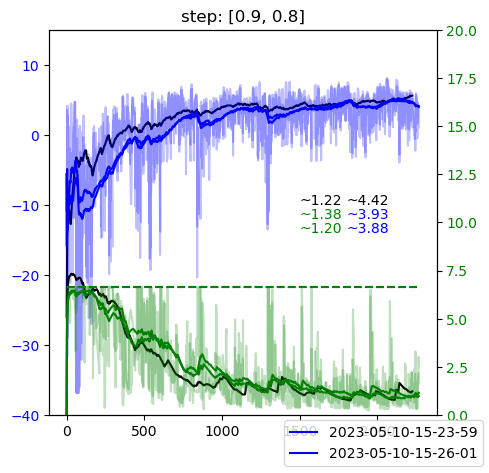

In [9]:
# %matplotlib qt
files = [
 # 'bubblewrap_run_2023-05-05-15-56-43.pickle',
 # 'bubblewrap_run_2023-05-05-15-56-50.pickle',
 # 'bubblewrap_run_2023-05-08-09-27-41.pickle',
 # 'bubblewrap_run_2023-05-08-09-36-03.pickle',
 # 'bubblewrap_run_2023-05-08-09-37-32.pickle', ### old way
 # 'bubblewrap_run_2023-05-08-09-39-30.pickle',
    # 'bubblewrap_run_2023-05-08-09-56-38.pickle',
    # 'bubblewrap_run_2023-05-08-09-58-44.pickle',
    # 'bubblewrap_run_2023-05-08-09-59-36.pickle',
    # 'bubblewrap_run_2023-05-08-10-00-47.pickle',
    # 'bubblewrap_run_2023-05-08-10-01-30.pickle',
     # 'bubblewrap_run_2023-05-08-10-06-16.pickle'
    # 'bubblewrap_run_2023-05-08-10-07-21.pickle',
    # 'bubblewrap_run_2023-05-09-09-43-46.pickle',
    # 'bubblewrap_run_2023-05-09-09-44-46.pickle',
    # 'bubblewrap_run_2023-05-09-10-01-32.pickle',
    # 'bubblewrap_run_2023-05-09-10-02-37.pickle',
    # 'bubblewrap_run_2023-05-09-10-03-49.pickle', ###
    # 'bubblewrap_run_2023-05-09-10-05-04.pickle', # B_trhesh -20
    # 'bubblewrap_run_2023-05-09-10-07-21.pickle', # epsilon 0
    # 'bubblewrap_run_2023-05-09-10-08-36.pickle', # step 9e-1 10x
    # 'bubblewrap_run_2023-05-09-10-10-27.pickle', # step 10x smaller
    # 'bubblewrap_run_2023-05-09-10-14-08.pickle', # step .01 bigger
    # 'bubblewrap_run_2023-05-09-10-15-15.pickle', # step .01 smaller
    # 'bubblewrap_run_2023-05-09-10-22-59.pickle', # m + 2
    # 'bubblewrap_run_2023-05-09-10-24-04.pickle', # m - 2
    # 'bubblewrap_run_2023-05-09-10-48-41.pickle', # eps 10x smaller
    # 'bubblewrap_run_2023-05-09-10-51-25.pickle', # eps 10x bigger
    # 'bubblewrap_run_2023-05-09-10-52-59.pickle', # eps 2x bigger
    # 'bubblewrap_run_2023-05-09-10-54-06.pickle' , # eps 2x smaller
    # 'bubblewrap_run_2023-05-09-11-05-36.pickle', # B_thresh -13
    # 'bubblewrap_run_2023-05-09-11-06-32.pickle', # B_thresh -17
    # 'bubblewrap_run_2023-05-09-11-16-03.pickle', # m 30 ###
    # 'bubblewrap_run_2023-05-09-11-15-11.pickle',
    # 'bubblewrap_run_2023-05-09-11-34-50.pickle',
    # 'bubblewrap_run_2023-05-09-11-36-21.pickle',  # bigger step
    # 'bubblewrap_run_2023-05-09-11-38-05.pickle',
    # 'bubblewrap_run_2023-05-09-11-56-56.pickle',
    # 'bubblewrap_run_2023-05-09-14-02-25.pickle',
    # 'bubblewrap_run_2023-05-09-14-16-50.pickle',
    # 'bubblewrap_run_2023-05-09-14-15-23.pickle',
    # 'bubblewrap_run_2023-05-09-14-08-16.pickle',
    # 'bubblewrap_run_2023-05-09-14-20-50.pickle',
    # 'bubblewrap_run_2023-05-09-14-34-17.pickle',
    # 'bubblewrap_run_2023-05-09-14-37-46.pickle',
    # 'bubblewrap_run_2023-05-09-14-39-36.pickle',
    # 'bubblewrap_run_2023-05-09-14-40-53.pickle',
    # 'bubblewrap_run_2023-05-10-15-22-26.pickle',
    'bubblewrap_run_2023-05-10-15-23-59.pickle',
    'bubblewrap_run_2023-05-10-15-26-01.pickle',
    # 'bubblewrap_run_2023-05-10-15-27-02.pickle',
    # 'bubblewrap_run_2023-05-10-15-28-25.pickle',
    # 'bubblewrap_run_2023-05-10-15-30-10.pickle',
    # 'bubblewrap_run_2023-05-10-15-31-24.pickle',
    # 'bubblewrap_run_2023-05-10-15-32-30.pickle',
]
brs = []
for file in files:
    with open(file, "rb") as fhan:
        br = pickle.load(fhan)
    brs.append(br)
plot_figure_4(brs,True)

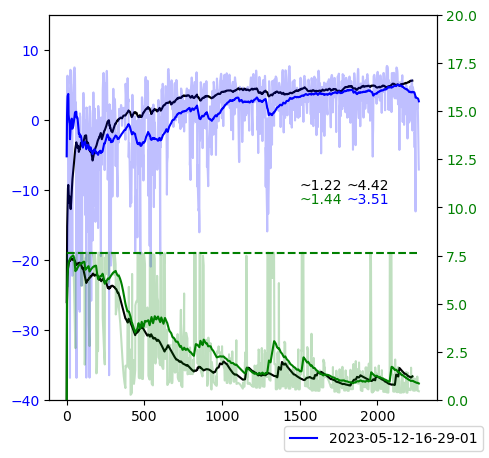

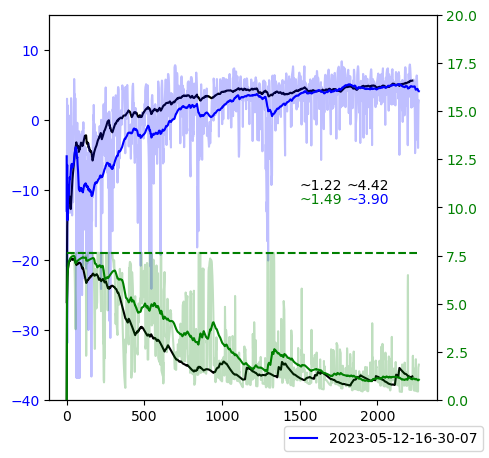

In [10]:
%matplotlib inline
files = [
 'bubblewrap_run_2023-05-12-16-29-01.pickle',
 'bubblewrap_run_2023-05-12-16-30-07.pickle',
]

for file in files:
    with open(file, "rb") as fhan:
        br = pickle.load(fhan)
    plot_figure_4([br,], True)

In [103]:
%matplotlib qt
path = ent_path # ent_path

avg =one_sided_ewma(br.entropy_list[:,0], com=100)


interp = np.interp(interp_x, path[:,0], path[:,1])

plt.plot(avg)
plt.plot(interp)
((avg - interp)**2).mean()

0.8826187103131531

In [105]:
plt.plot(avg[avg.shape[0]//2:])

In [57]:
avg.shape[0]-ent_path[-1,0]

42.99367761470194